# Analyzing and reporcessing data 


# Dataset Description 
Data consists of 4653 record with 9 features related to emloyee information.
Dataset is available here: https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset

**The dataset contains the following columns:**
* Education: Employee’s education level (categorical).
* JoiningYear: The year the employee joined the company (numerical).
* City: The city where the employee works (categorical).
* PaymentTier: Employee’s salary tier (1-3) (numerical).
* Age: Employee’s age in years (numerical).
* Gender: Employee’s gender (categorical).
* EverBenched: Whether the employee was ever benched (yes/no) (categorical).
* ExperienceInCurrentDomain: Number of years of experience in the current domain (numerical).
* LeaveOrNot: Binary variable indicating if the employee left the company (1 = left, 0 = stayed) (binary).

There are no missing values in the dataset. The dataset is suitable for analyzing employee retention. payment structure and trends, as well as classification of the possible leavers.

In [376]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [377]:
DATA_PATH = '../data/raw/Employee.csv'
DIRTY_DATA_PATH = '../data/processed/Employee_with_missing_data.csv'

# df = pd.read_csv(DATA_PATH)
df = pd.read_csv(DIRTY_DATA_PATH)

df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bachelors,2013.0,Pune,1.0,28.0,Female,No,3.0,1.0
2,Bachelors,2014.0,New Delhi,3.0,38.0,Female,No,2.0,0.0
3,Masters,2016.0,Bangalore,3.0,27.0,Male,No,5.0,1.0
4,Masters,2017.0,Pune,3.0,24.0,Male,Yes,2.0,1.0


In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Education                  4188 non-null   object 
 1   JoiningYear                4188 non-null   float64
 2   City                       4188 non-null   object 
 3   PaymentTier                4188 non-null   float64
 4   Age                        4188 non-null   float64
 5   Gender                     4188 non-null   object 
 6   EverBenched                4188 non-null   object 
 7   ExperienceInCurrentDomain  4188 non-null   float64
 8   LeaveOrNot                 4188 non-null   float64
dtypes: float64(5), object(4)
memory usage: 327.3+ KB


In [379]:
df.describe(include='all')

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
count,4188,4188.000000,4188,4188.000000,4188.000000,4188,4188,4188.000000,4188.000000
unique,3,NaN,3,NaN,NaN,2,2,NaN,NaN
top,Bachelors,NaN,Bangalore,NaN,NaN,Male,No,NaN,NaN
freq,3242,NaN,2018,NaN,NaN,2513,3758,NaN,NaN
mean,NaN,2015.053247,NaN,2.697230,29.389924,NaN,NaN,2.893505,0.340258
std,NaN,1.864859,NaN,0.563623,4.830202,NaN,NaN,1.565885,0.473852
min,NaN,2012.000000,NaN,1.000000,22.000000,NaN,NaN,0.000000,0.000000
25%,NaN,2013.000000,NaN,3.000000,26.000000,NaN,NaN,2.000000,0.000000
50%,NaN,2015.000000,NaN,3.000000,28.000000,NaN,NaN,3.000000,0.000000
75%,NaN,2017.000000,NaN,3.000000,32.000000,NaN,NaN,4.000000,1.000000


In [380]:
print('___Num of N/As\n',df.isna().sum())

___Num of N/As
 Education                    465
JoiningYear                  465
City                         465
PaymentTier                  465
Age                          465
Gender                       465
EverBenched                  465
ExperienceInCurrentDomain    465
LeaveOrNot                   465
dtype: int64


In [381]:
print('___Num of Nulls__\n',df.isnull().any())

___Num of Nulls__
 Education                    True
JoiningYear                  True
City                         True
PaymentTier                  True
Age                          True
Gender                       True
EverBenched                  True
ExperienceInCurrentDomain    True
LeaveOrNot                   True
dtype: bool


In [382]:
missing_data = df.isnull().mean() * 100

print("Percentage of Missing Data in Each Column:")
print(missing_data)

Percentage of Missing Data in Each Column:
Education                    9.993553
JoiningYear                  9.993553
City                         9.993553
PaymentTier                  9.993553
Age                          9.993553
Gender                       9.993553
EverBenched                  9.993553
ExperienceInCurrentDomain    9.993553
LeaveOrNot                   9.993553
dtype: float64


Z racji na brak brakujących danych w oryginalnych zbiorze danych, brakujące dan dodano sztucznie za pomocą skryptu `add_missing_data.py`.

W celu zaadresowania brakujących danych skorzystano z 2 "prostszych" rozwiązań i jednego "zaawansowanego":
* Średnia - dla danych numerycznych
* Najczęściej występująca wartość - dla danych kategorycznych
* Algorytm K najbliższych sąsiadów - jako zaawansowane rozwiązanie

In [383]:
from sklearn.impute import KNNImputer
import numpy as np
np.float = np.float64 

In [384]:
def mean_imputation(data):
    data = data.copy()
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

    for col in numeric_cols:
        if data[col].isnull().any():
            mean_value = data[col].mean()
            data[col] = data[col].fillna(mean_value)
        else:
            print(f"No missing data to impute in column {col}.")

    return data

In [385]:
def knn_imputation(data, n_neighbors=5):
    data = data.copy()
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    data[numeric_cols] = knn_imputer.fit_transform(data[numeric_cols])
    return data

In [386]:
def median_mode_imputation(data):
    data = data.copy()
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = data.select_dtypes(include=['object']).columns

    # Numeric columns - Median imputation
    for col in numeric_cols:
        if data[col].isnull().any():
            median_value = data[col].median()
            data[col] = data[col].fillna(median_value)
        else:
            print(f"No missing numeric data to impute in column {col}.")

    # Categorical columns - Mode imputation
    for col in categorical_cols:
        if data[col].isnull().any():
            most_frequent = data[col].mode()[0]
            data[col] = data[col].fillna(most_frequent)
        else:
            print(f"No missing categorical data to impute in column {col}.")

    return data

Ostatecznie w celu całkowitego wyczyszczenia danych z brakujących wartości, zdecydowano się na uzupełnienie brakujących wartości za pomocą mediany dla danych numerycznych i najczęściej występującej wartości dla danych kategorycznych. Reszta wersji z uzupełnionymi danymi została zachowana w folderze `data/processed`.

In [387]:
methods = {
    'MedianMode': median_mode_imputation,
    'Mean': mean_imputation,
    'KNN_3': lambda data: knn_imputation(data, n_neighbors=3),
    'KNN_5': lambda data: knn_imputation(data, n_neighbors=5),
}

output_dir = '../data/processed/imputation_results'
os.makedirs(output_dir, exist_ok=True)

results = []

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
    
num_missing_before = df[numeric_cols].isnull().sum().sum()
cat_missing_before = df[categorical_cols].isnull().sum().sum()

print(" --- Number of missing values before imputation: ---")
print(f"Before imputation (numeric): {num_missing_before}")
print(f"Before imputation (categorical): {cat_missing_before}\n")
    
# Testing each function
for method_name, impute_function in methods.items():
    df_imputed = impute_function(df.copy())
    
    num_missing_after = df_imputed[numeric_cols].isnull().sum().sum()
    cat_missing_after = df_imputed[categorical_cols].isnull().sum().sum()
    
    num_filled = num_missing_before - num_missing_after
    cat_filled = cat_missing_before - cat_missing_after
    
    output_path = os.path.join(output_dir, f'Employee_{method_name}_imputed.csv')
    df_imputed.to_csv(output_path, index=False)
    
    
    print(f"> Imputation method: {method_name}")
    print(f"After imputation (numeric): {num_missing_after}")
    print(f"After imputation (categorical): {cat_missing_after}")
    print(f"Dataset for {method_name} saved to {output_path}\n")


 --- Number of missing values before imputation: ---
Before imputation (numeric): 2325
Before imputation (categorical): 1860

> Imputation method: MedianMode
After imputation (numeric): 0
After imputation (categorical): 0
Dataset for MedianMode saved to ../data/processed/imputation_results/Employee_MedianMode_imputed.csv

> Imputation method: Mean
After imputation (numeric): 0
After imputation (categorical): 1860
Dataset for Mean saved to ../data/processed/imputation_results/Employee_Mean_imputed.csv

> Imputation method: KNN_3
After imputation (numeric): 0
After imputation (categorical): 1860
Dataset for KNN_3 saved to ../data/processed/imputation_results/Employee_KNN_3_imputed.csv

> Imputation method: KNN_5
After imputation (numeric): 0
After imputation (categorical): 1860
Dataset for KNN_5 saved to ../data/processed/imputation_results/Employee_KNN_5_imputed.csv



In [388]:
df = pd.read_csv('../data/processed/imputation_results/Employee_MedianMode_imputed.csv')

## Analiza danych

<Figure size 1400x1000 with 0 Axes>

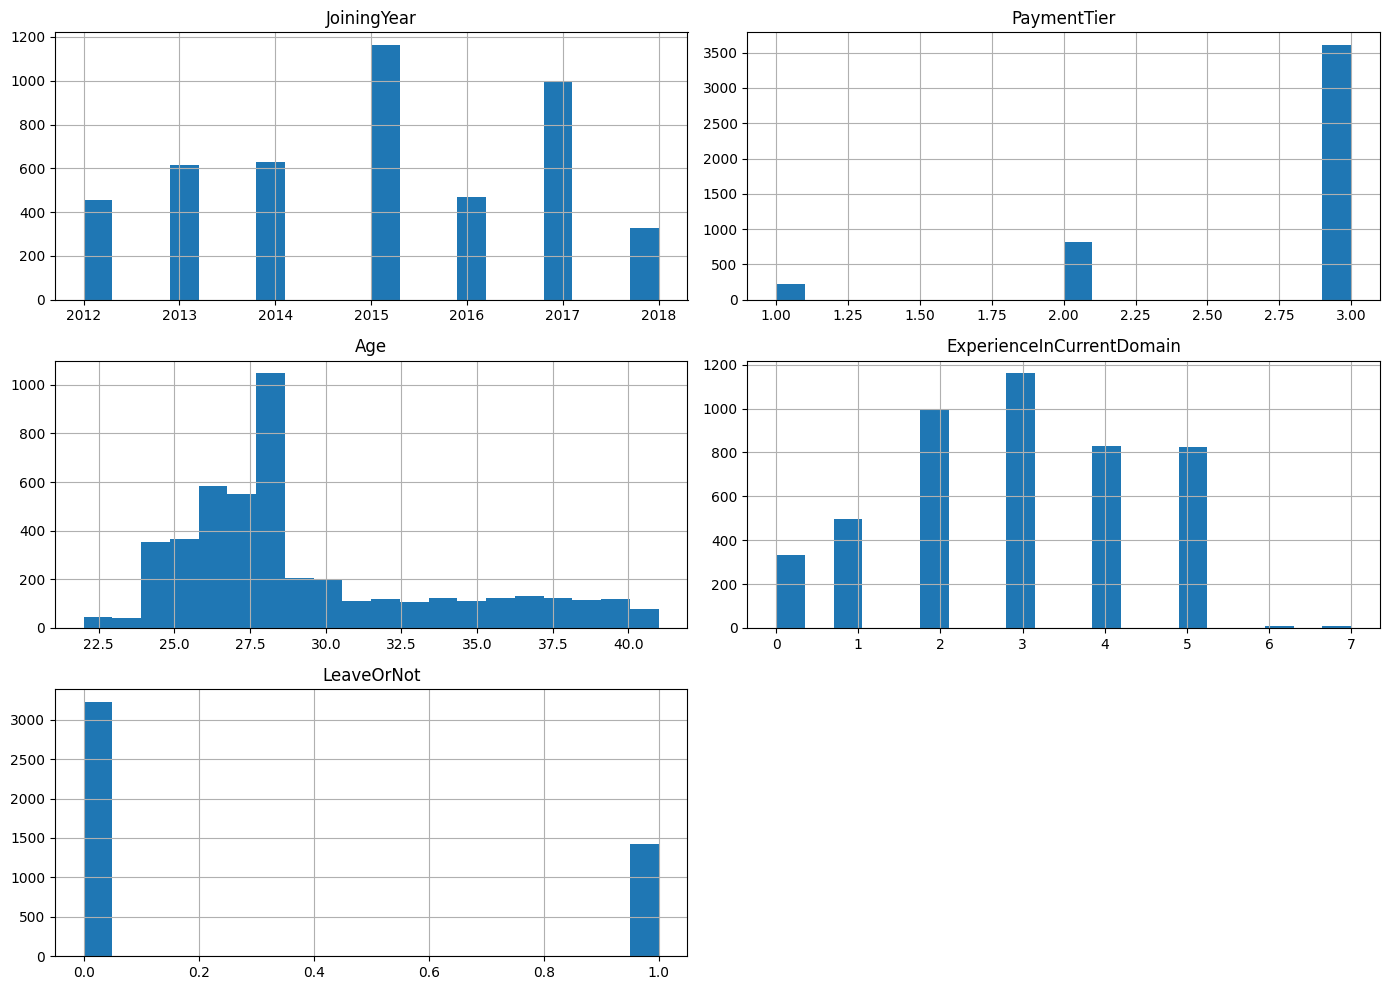

In [389]:
plt.figure(figsize=(14, 10))
df.hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

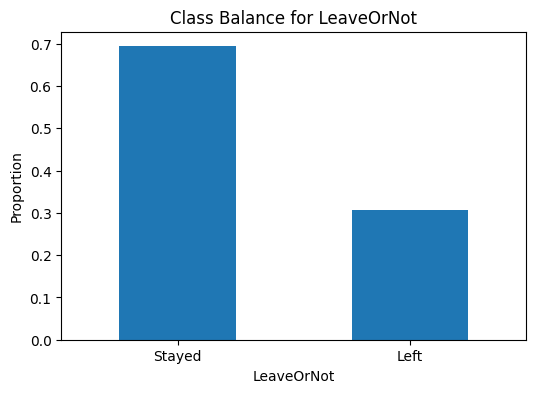

In [390]:
class_balance = df['LeaveOrNot'].value_counts(normalize=True)

# Bar chart for class balance
plt.figure(figsize=(6, 4))
class_balance.plot(kind='bar')
plt.title('Class Balance for LeaveOrNot')
plt.xlabel('LeaveOrNot')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Stayed', 'Left'], rotation=0)
plt.show()

<Axes: xlabel='Education', ylabel='count'>

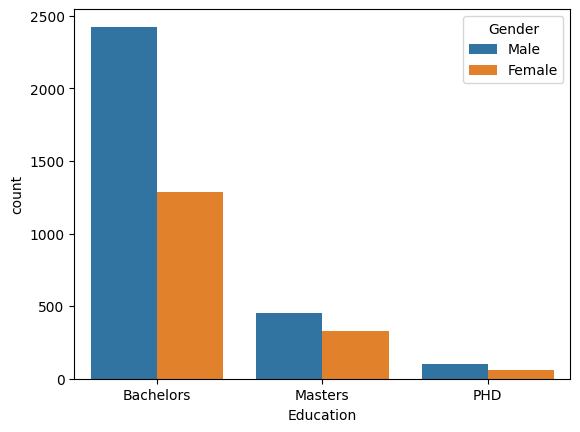

In [391]:
sns.countplot(data=df,x=df.Education,hue='Gender')

<Axes: xlabel='ExperienceInCurrentDomain', ylabel='count'>

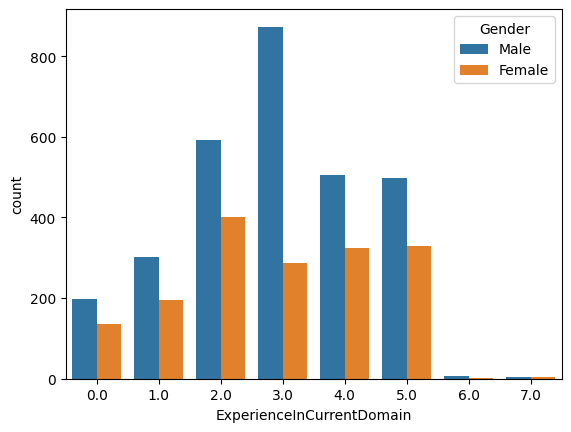

In [392]:
sns.countplot(data=df,x='ExperienceInCurrentDomain',hue='Gender')

Text(0.5, 1.0, 'Employee Turnover by Joining Year')

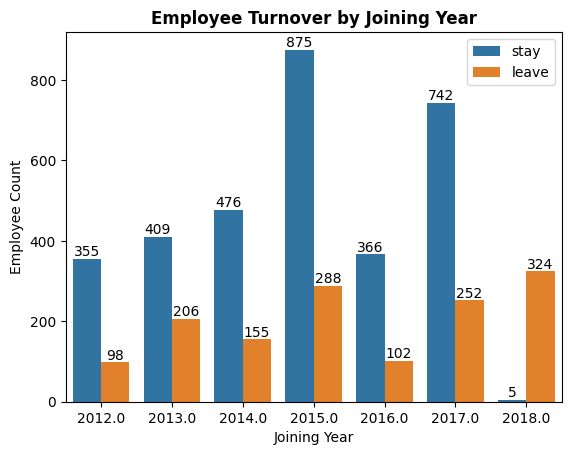

In [393]:
countplot = sns.countplot(x = 'JoiningYear' , hue = 'LeaveOrNot', data = df)
for count in countplot.containers:
    countplot.bar_label(count,)
plt.xlabel("Joining Year")
plt.ylabel("Employee Count")
plt.legend(labels = ["stay", "leave"])
plt.title("Employee Turnover by Joining Year", fontweight = "bold")

Text(0.5, 1.0, 'Employee Turnover by Gender')

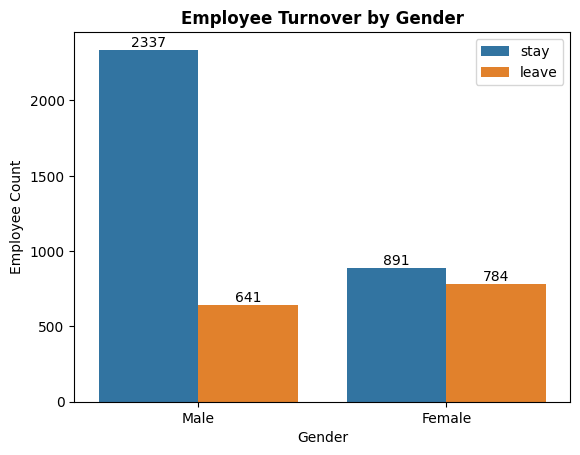

In [394]:
countplot = sns.countplot(x = "Gender", hue = "LeaveOrNot", data = df)
for count in countplot.containers:
    countplot.bar_label(count,)
plt.xlabel("Gender")
plt.ylabel("Employee Count")
plt.legend(labels = ["stay", "leave"])
plt.title("Employee Turnover by Gender", fontweight = "bold")

Text(0.5, 1.0, 'Employee Turnover by Payment Tier')

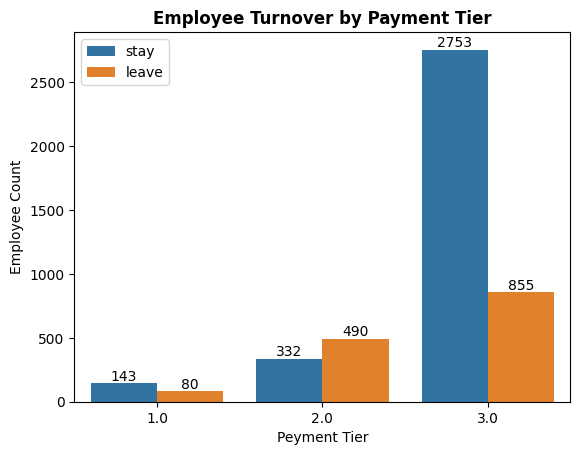

In [395]:
countplot = sns.countplot(x = 'PaymentTier' , hue = 'LeaveOrNot', data = df)
for count in countplot.containers:
    countplot.bar_label(count,)
plt.xlabel("Peyment Tier")
plt.ylabel("Employee Count")
plt.legend(labels = ["stay", "leave"])
plt.title("Employee Turnover by Payment Tier", fontweight = "bold")

<Figure size 1200x800 with 0 Axes>

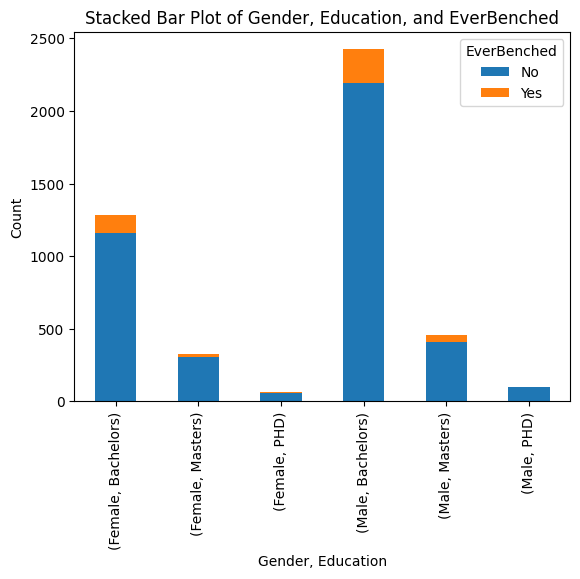

In [396]:
x = pd.crosstab([df['Gender'], df['Education']], df['EverBenched'])

plt.figure(figsize=(12, 8))

x.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Plot of Gender, Education, and EverBenched')
plt.xlabel('Gender, Education')
plt.ylabel('Count')

plt.show()

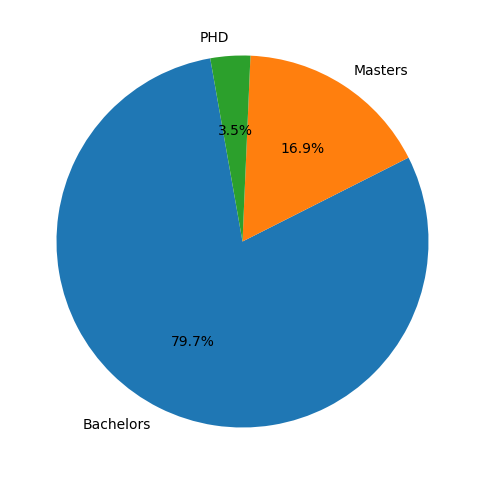

In [397]:
edu_count=df.Education.value_counts()
plt.figure(figsize=(6, 8))
plt.pie(edu_count, labels=edu_count.index, autopct='%1.1f%%', startangle=100)
plt.show()

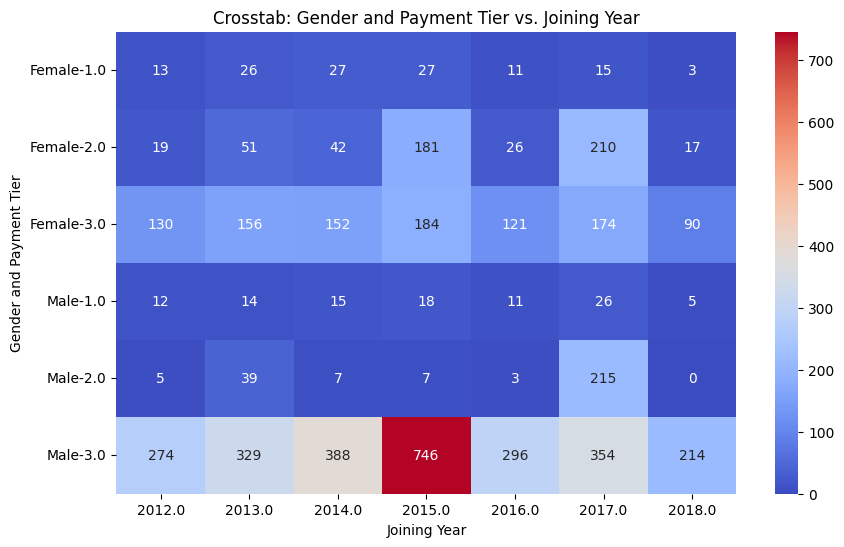

In [398]:
x=pd.crosstab([df.Gender,df.PaymentTier],df.JoiningYear)
plt.figure(figsize=(10, 6))
sns.heatmap(x, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Joining Year')
plt.ylabel('Gender and Payment Tier')
plt.title('Crosstab: Gender and Payment Tier vs. Joining Year')
plt.show()

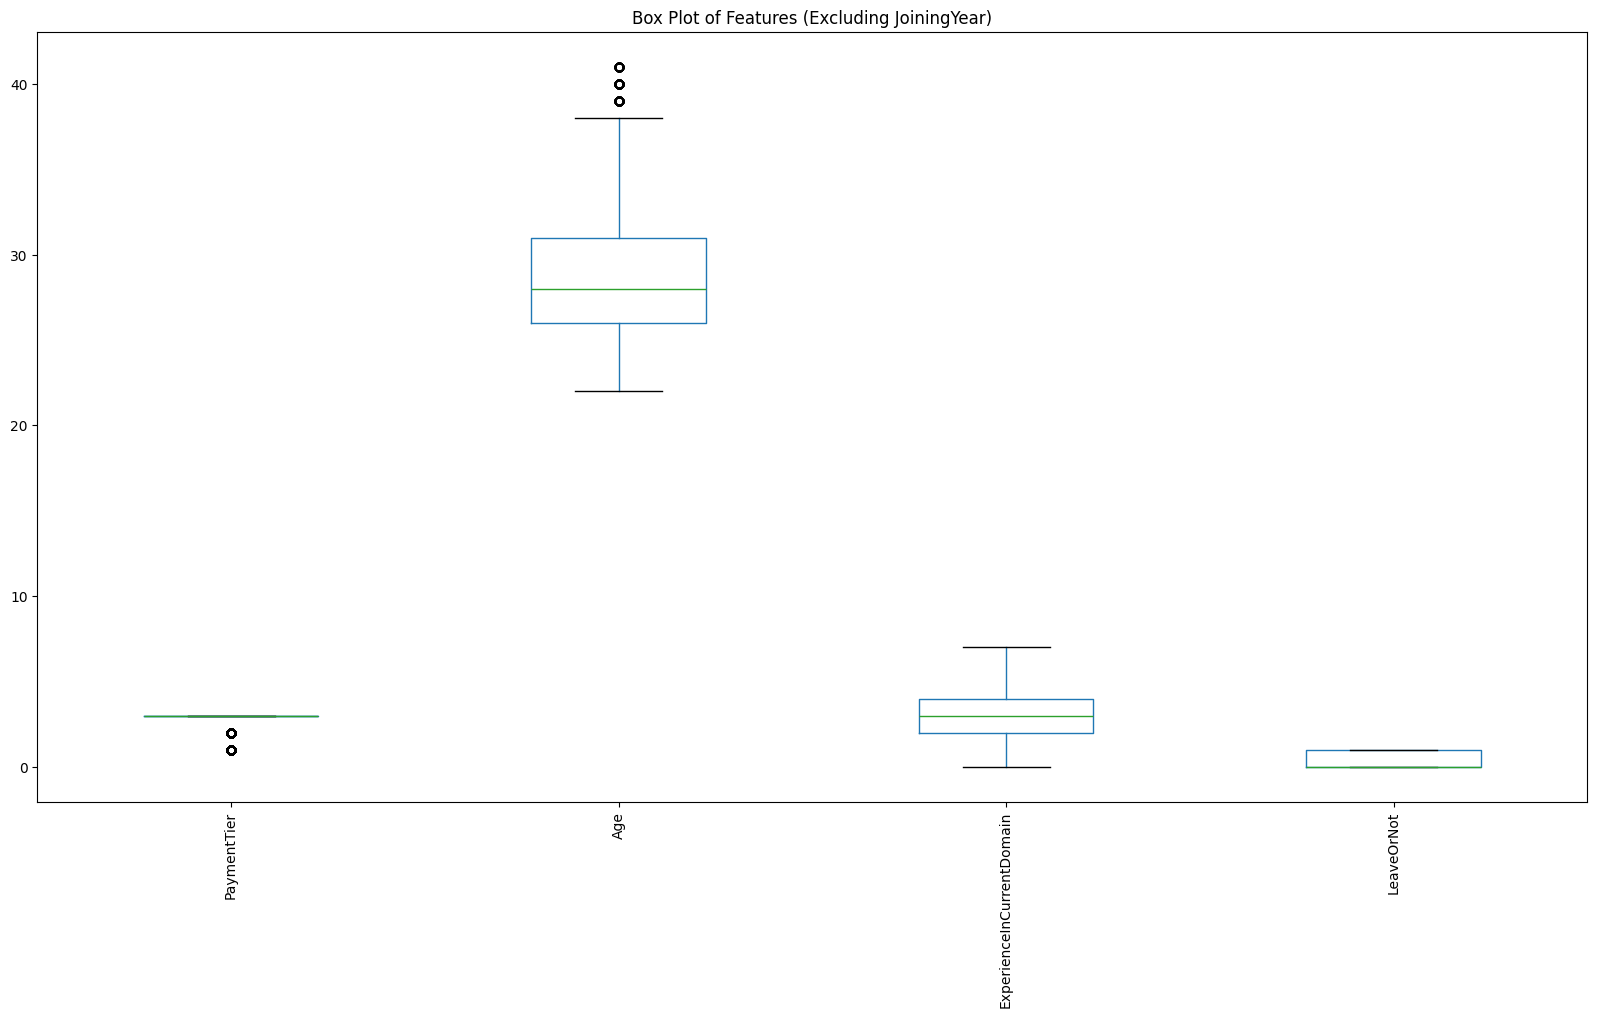

In [399]:
excluded_columns = ['JoiningYear']

columns_to_plot = [col for col in df.columns if col not in excluded_columns]

# Creating the boxplot
plt.figure(figsize=(20, 10))
df[columns_to_plot].boxplot(rot=45)
plt.title("Box Plot of Features (Excluding JoiningYear)")
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

In [400]:
print(df['Age'].idxmax())
print(df['Age'].max())
df['Age'].value_counts()

3004
41.0


Age
28.0    1047
26.0     583
27.0     551
25.0     367
24.0     353
29.0     205
30.0     200
37.0     130
36.0     124
38.0     123
34.0     123
40.0     119
32.0     117
39.0     114
35.0     112
31.0     111
33.0     108
41.0      77
22.0      47
23.0      42
Name: count, dtype: int64

In [401]:
# Most frequent city
most_common_city = df['City'].value_counts().idxmax()
print(f"The city with the most employees is: {most_common_city}")

# City with the highest leavers
city_leavers = df[df['LeaveOrNot'] == 1]['City'].value_counts().idxmax()
print(f"The city with the highest number of leavers is: {city_leavers}")

The city with the most employees is: Bangalore
The city with the highest number of leavers is: Pune


In [402]:
from scipy.stats import pearsonr, spearmanr

numerical_pairs = [('Age', 'ExperienceInCurrentDomain'), ('JoiningYear', 'ExperienceInCurrentDomain')]

for pair in numerical_pairs:
    pearson_corr, _ = pearsonr(df[pair[0]], df[pair[1]])
    spearman_corr, _ = spearmanr(df[pair[0]], df[pair[1]])
    print(f"Correlation between {pair[0]} and {pair[1]}:")
    print(f"  Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}\n")

Correlation between Age and ExperienceInCurrentDomain:
  Pearson: -0.13, Spearman: -0.17

Correlation between JoiningYear and ExperienceInCurrentDomain:
  Pearson: -0.04, Spearman: -0.05



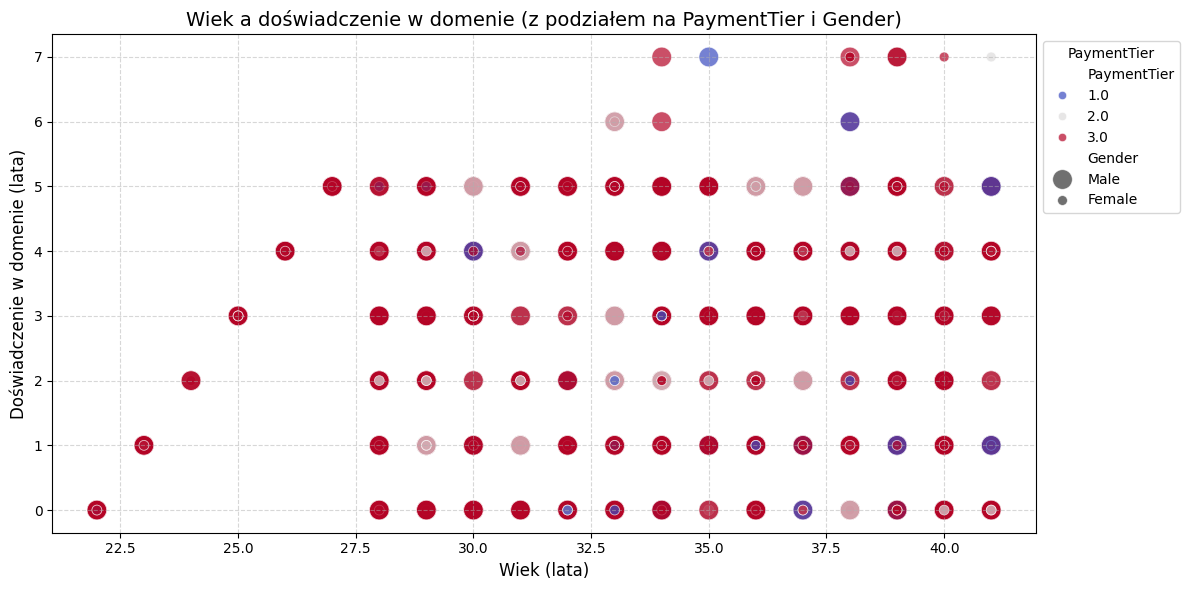

In [403]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Age',
    y='ExperienceInCurrentDomain',
    data=df,
    hue='PaymentTier',
    size='Gender',
    sizes=(50, 200),
    palette='coolwarm',
    alpha=0.7
)
plt.title('Wiek a doświadczenie w domenie (z podziałem na PaymentTier i Gender)', fontsize=14)
plt.xlabel('Wiek (lata)', fontsize=12)
plt.ylabel('Doświadczenie w domenie (lata)', fontsize=12)
plt.legend(title="PaymentTier", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Przetwarzanie zbiorów
Dla kadego z 4 zbiórów danych z uzupełnionymi danymi brakującymi, przeprowadzono następujące operacje:
* Kodowanie zmiennych kategorycznych
* Skalowanie zmiennych numerycznych
* Standaryzacja zmiennych numerycznych

In [404]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler

input_dir = '../data/processed/imputation_results'
output_dir = '../data/processed/scaled_results'
os.makedirs(output_dir, exist_ok=True)

imputed_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

for file_name in imputed_files:
    file_path = os.path.join(input_dir, file_name)
    
    df = pd.read_csv(file_path)
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    df_minmax_scaled = df.copy()
    df_minmax_scaled[numeric_cols] = pd.DataFrame(
        min_max_scaler.fit_transform(df_minmax_scaled[numeric_cols]),
        columns=numeric_cols,
        index=df.index
    )
    minmax_output_path = os.path.join(output_dir, f"{file_name.split('.')[0]}_minmax_scaled.csv")
    df_minmax_scaled.to_csv(minmax_output_path, index=False)
    print(f"Min-Max Scaled dataset saved to {minmax_output_path}")
    
    df_standard_scaled = df.copy()
    df_standard_scaled[numeric_cols] = pd.DataFrame(
        standard_scaler.fit_transform(df_standard_scaled[numeric_cols]),
        columns=numeric_cols,
        index=df.index
    )
    standard_output_path = os.path.join(output_dir, f"{file_name.split('.')[0]}_standard_scaled.csv")
    df_standard_scaled.to_csv(standard_output_path, index=False)
    print(f"Standard Scaled dataset saved to {standard_output_path}")

Min-Max Scaled dataset saved to ../data/processed/scaled_results/Employee_KNN_5_imputed_minmax_scaled.csv
Standard Scaled dataset saved to ../data/processed/scaled_results/Employee_KNN_5_imputed_standard_scaled.csv
Min-Max Scaled dataset saved to ../data/processed/scaled_results/Employee_MedianMode_imputed_minmax_scaled.csv
Standard Scaled dataset saved to ../data/processed/scaled_results/Employee_MedianMode_imputed_standard_scaled.csv
Min-Max Scaled dataset saved to ../data/processed/scaled_results/Employee_KNN_3_imputed_minmax_scaled.csv
Standard Scaled dataset saved to ../data/processed/scaled_results/Employee_KNN_3_imputed_standard_scaled.csv
Min-Max Scaled dataset saved to ../data/processed/scaled_results/Employee_Mean_imputed_minmax_scaled.csv
Standard Scaled dataset saved to ../data/processed/scaled_results/Employee_Mean_imputed_standard_scaled.csv
Min-Max Scaled dataset saved to ../data/processed/scaled_results/Employee_KNN_7_imputed_minmax_scaled.csv
Standard Scaled dataset sa

In [405]:
df = pd.read_csv('../data/processed/scaled_results/Employee_MedianMode_imputed_minmax_scaled.csv')

## Analiza danych po przetworzeniu zbiorów

In [406]:
df.head()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,Education_Masters,Education_PHD,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes
0,0.500000,1.0,0.315789,0.428571,0.0,False,False,False,False,True,False
1,0.166667,0.0,0.315789,0.428571,1.0,False,False,False,True,False,False
2,0.333333,1.0,0.842105,0.285714,0.0,False,False,True,False,False,False
3,0.666667,1.0,0.263158,0.714286,1.0,True,False,False,False,True,False
4,0.833333,1.0,0.105263,0.285714,1.0,True,False,False,True,True,True


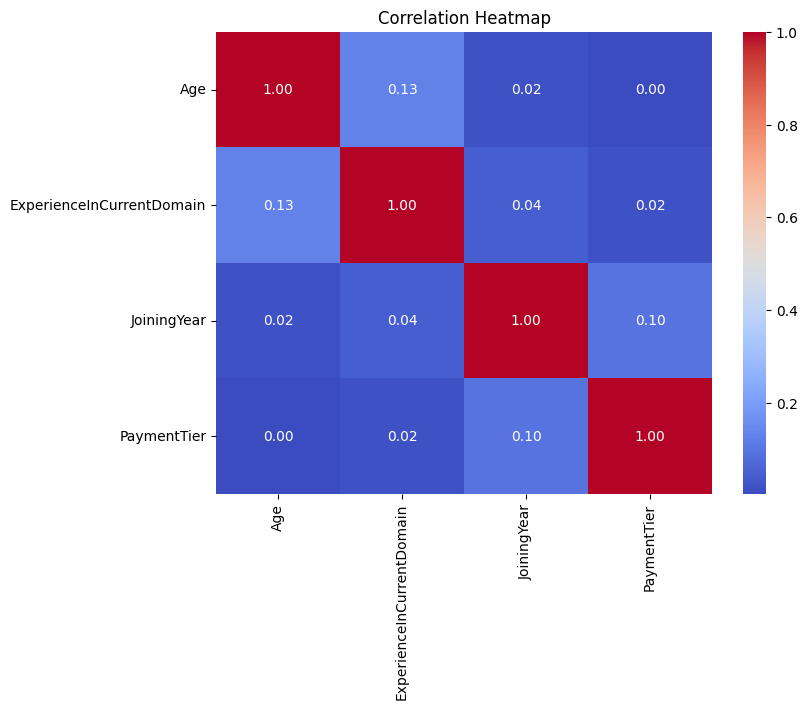

In [407]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Age', 'ExperienceInCurrentDomain', 'JoiningYear', 'PaymentTier']].corr().abs()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

<Axes: >

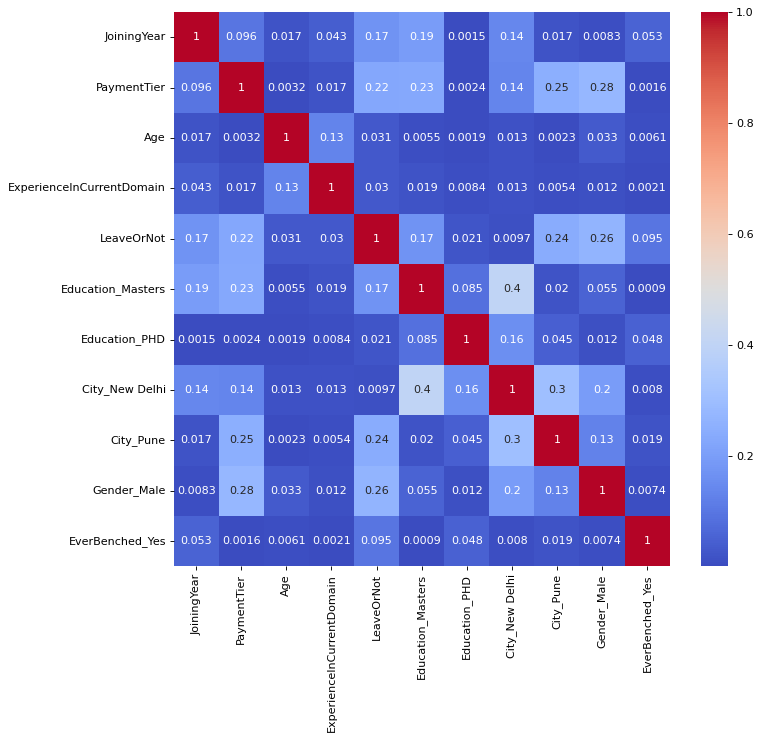

In [408]:
from matplotlib.pyplot import figure

figure(figsize=(10, 9), dpi=80)

corrMatrix = df.corr().abs()
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')

In [409]:
strong_corr_pairs = (
    corrMatrix.unstack()
    .sort_values(kind="quicksort", ascending=False)
    .drop_duplicates()
)
strong_corr_pairs = strong_corr_pairs[(strong_corr_pairs > 0.2) & (strong_corr_pairs < 1)]
print(strong_corr_pairs.head())

Education_Masters  City_New Delhi    0.402831
City_New Delhi     City_Pune         0.303775
PaymentTier        Gender_Male       0.275380
Gender_Male        LeaveOrNot        0.263268
PaymentTier        City_Pune         0.249148
dtype: float64


<Axes: >

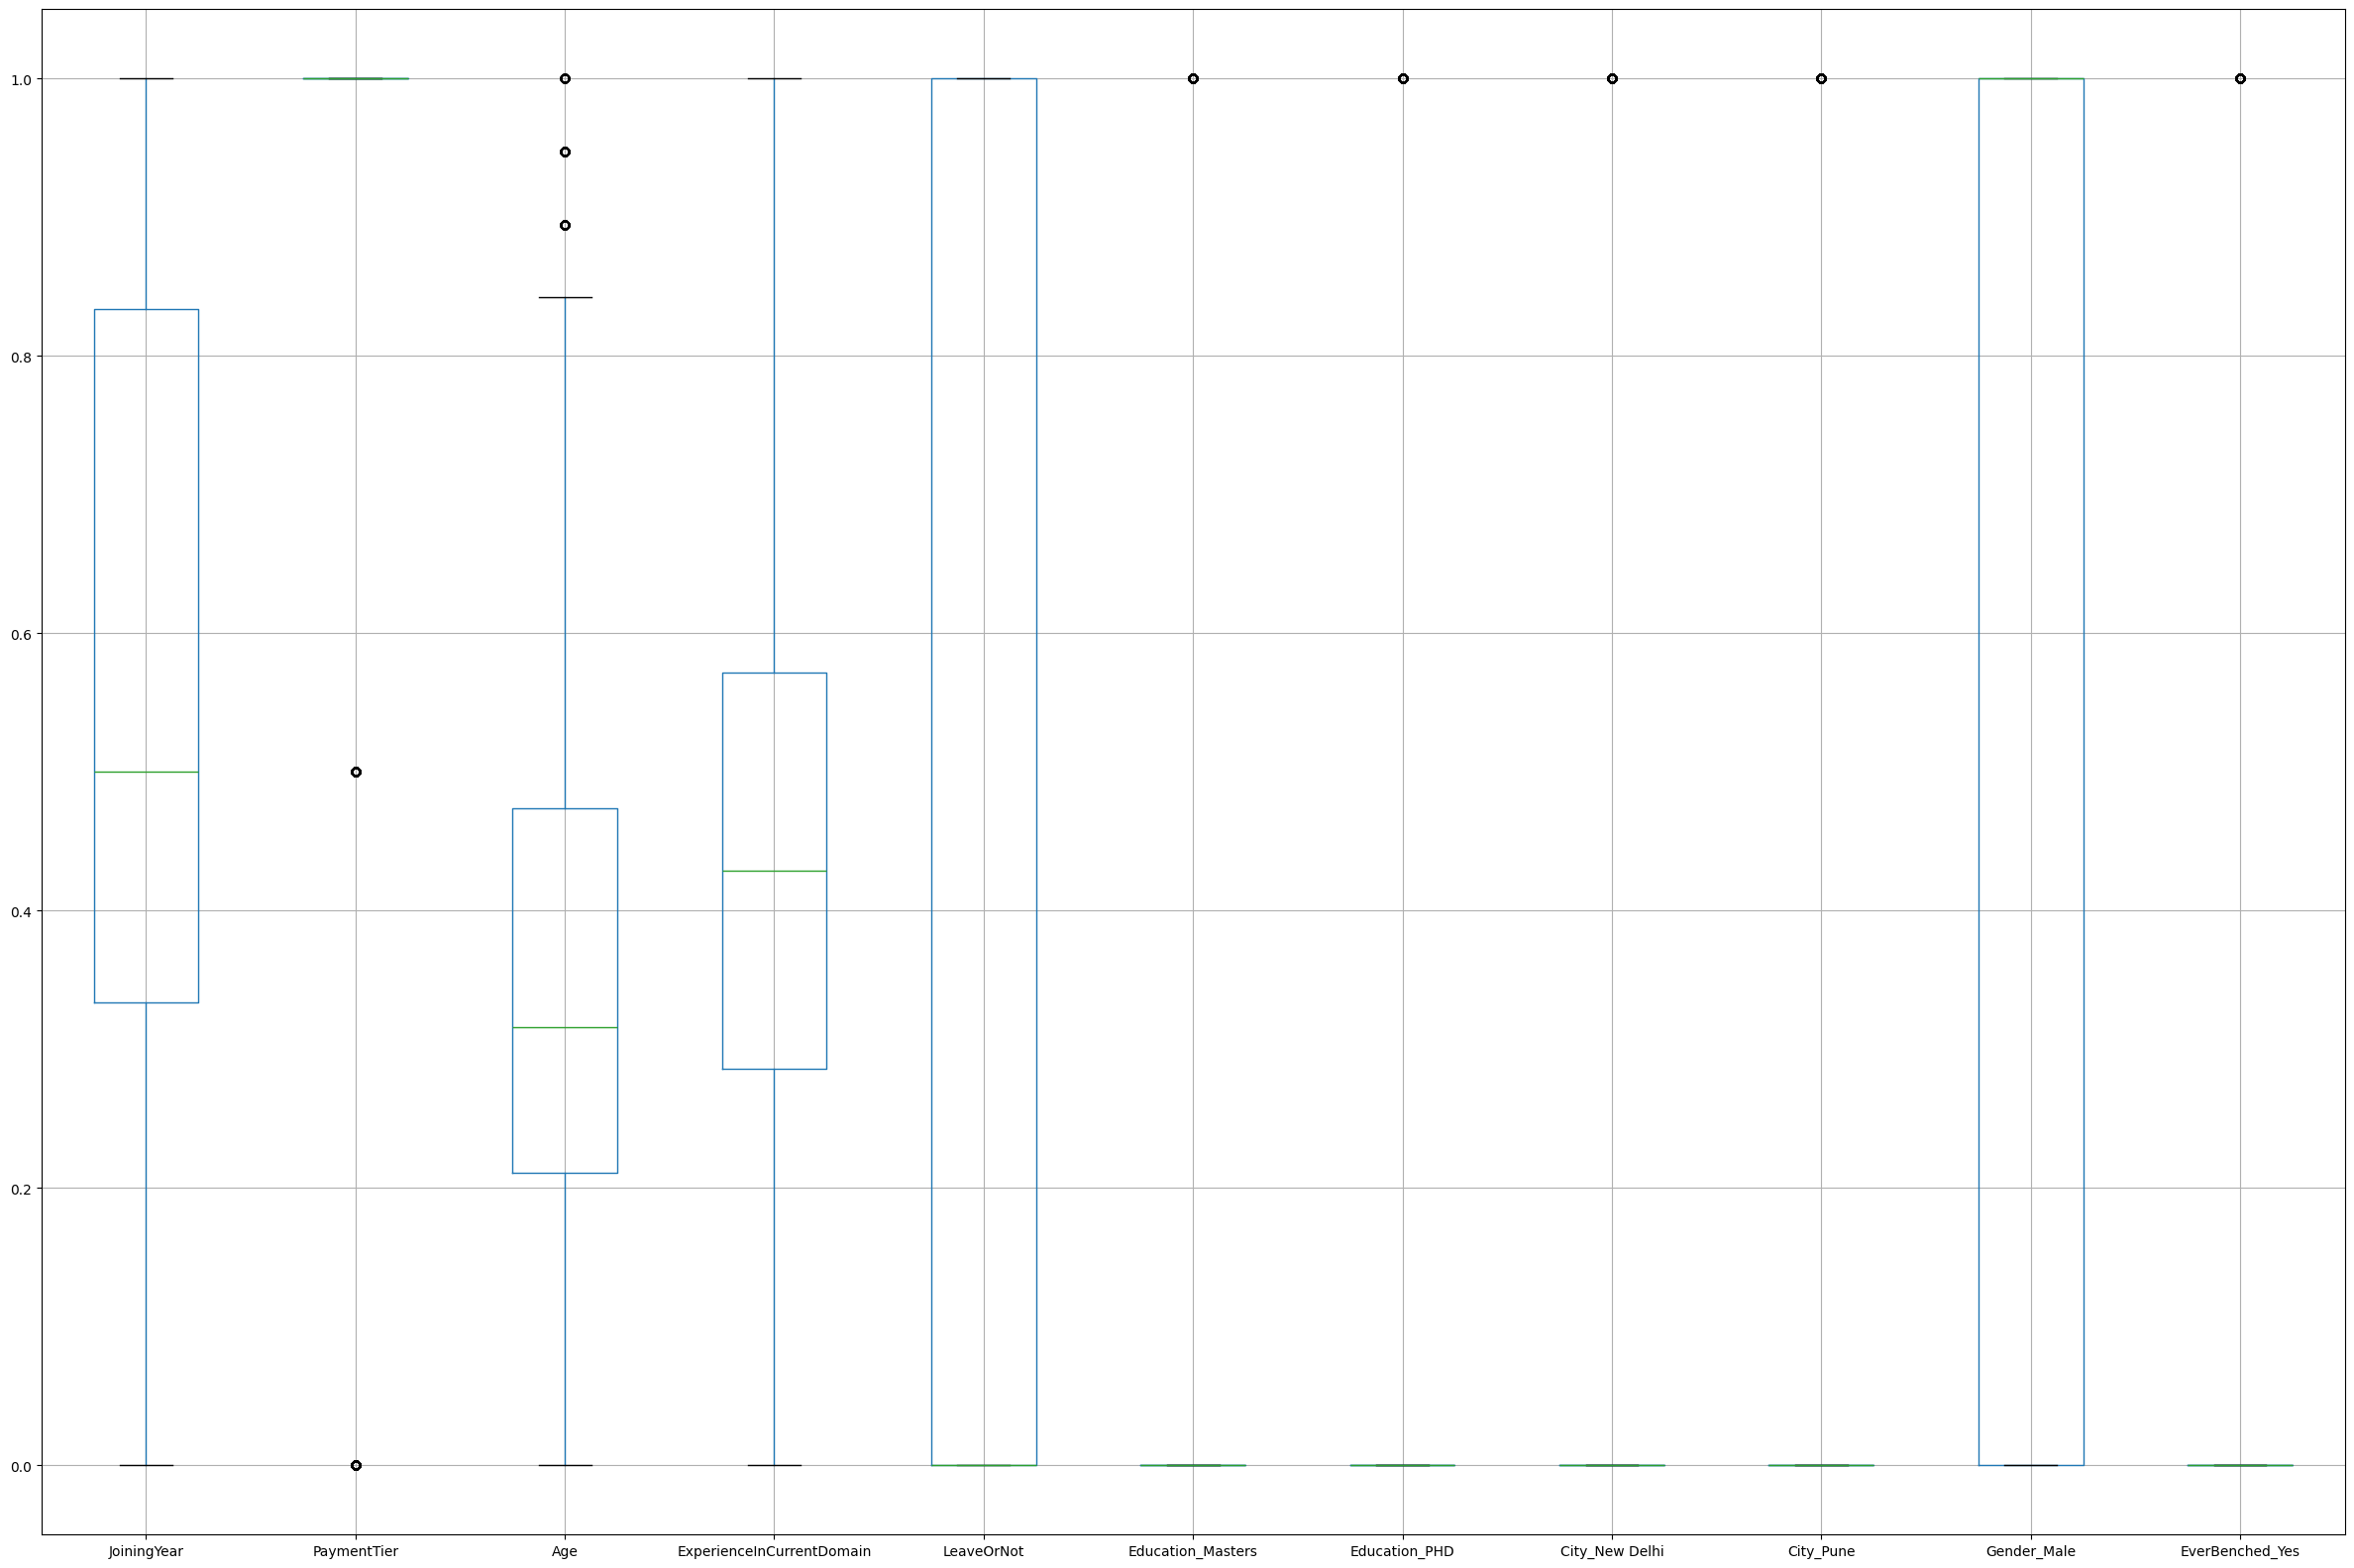

In [410]:
df.boxplot(figsize=(30, 20))

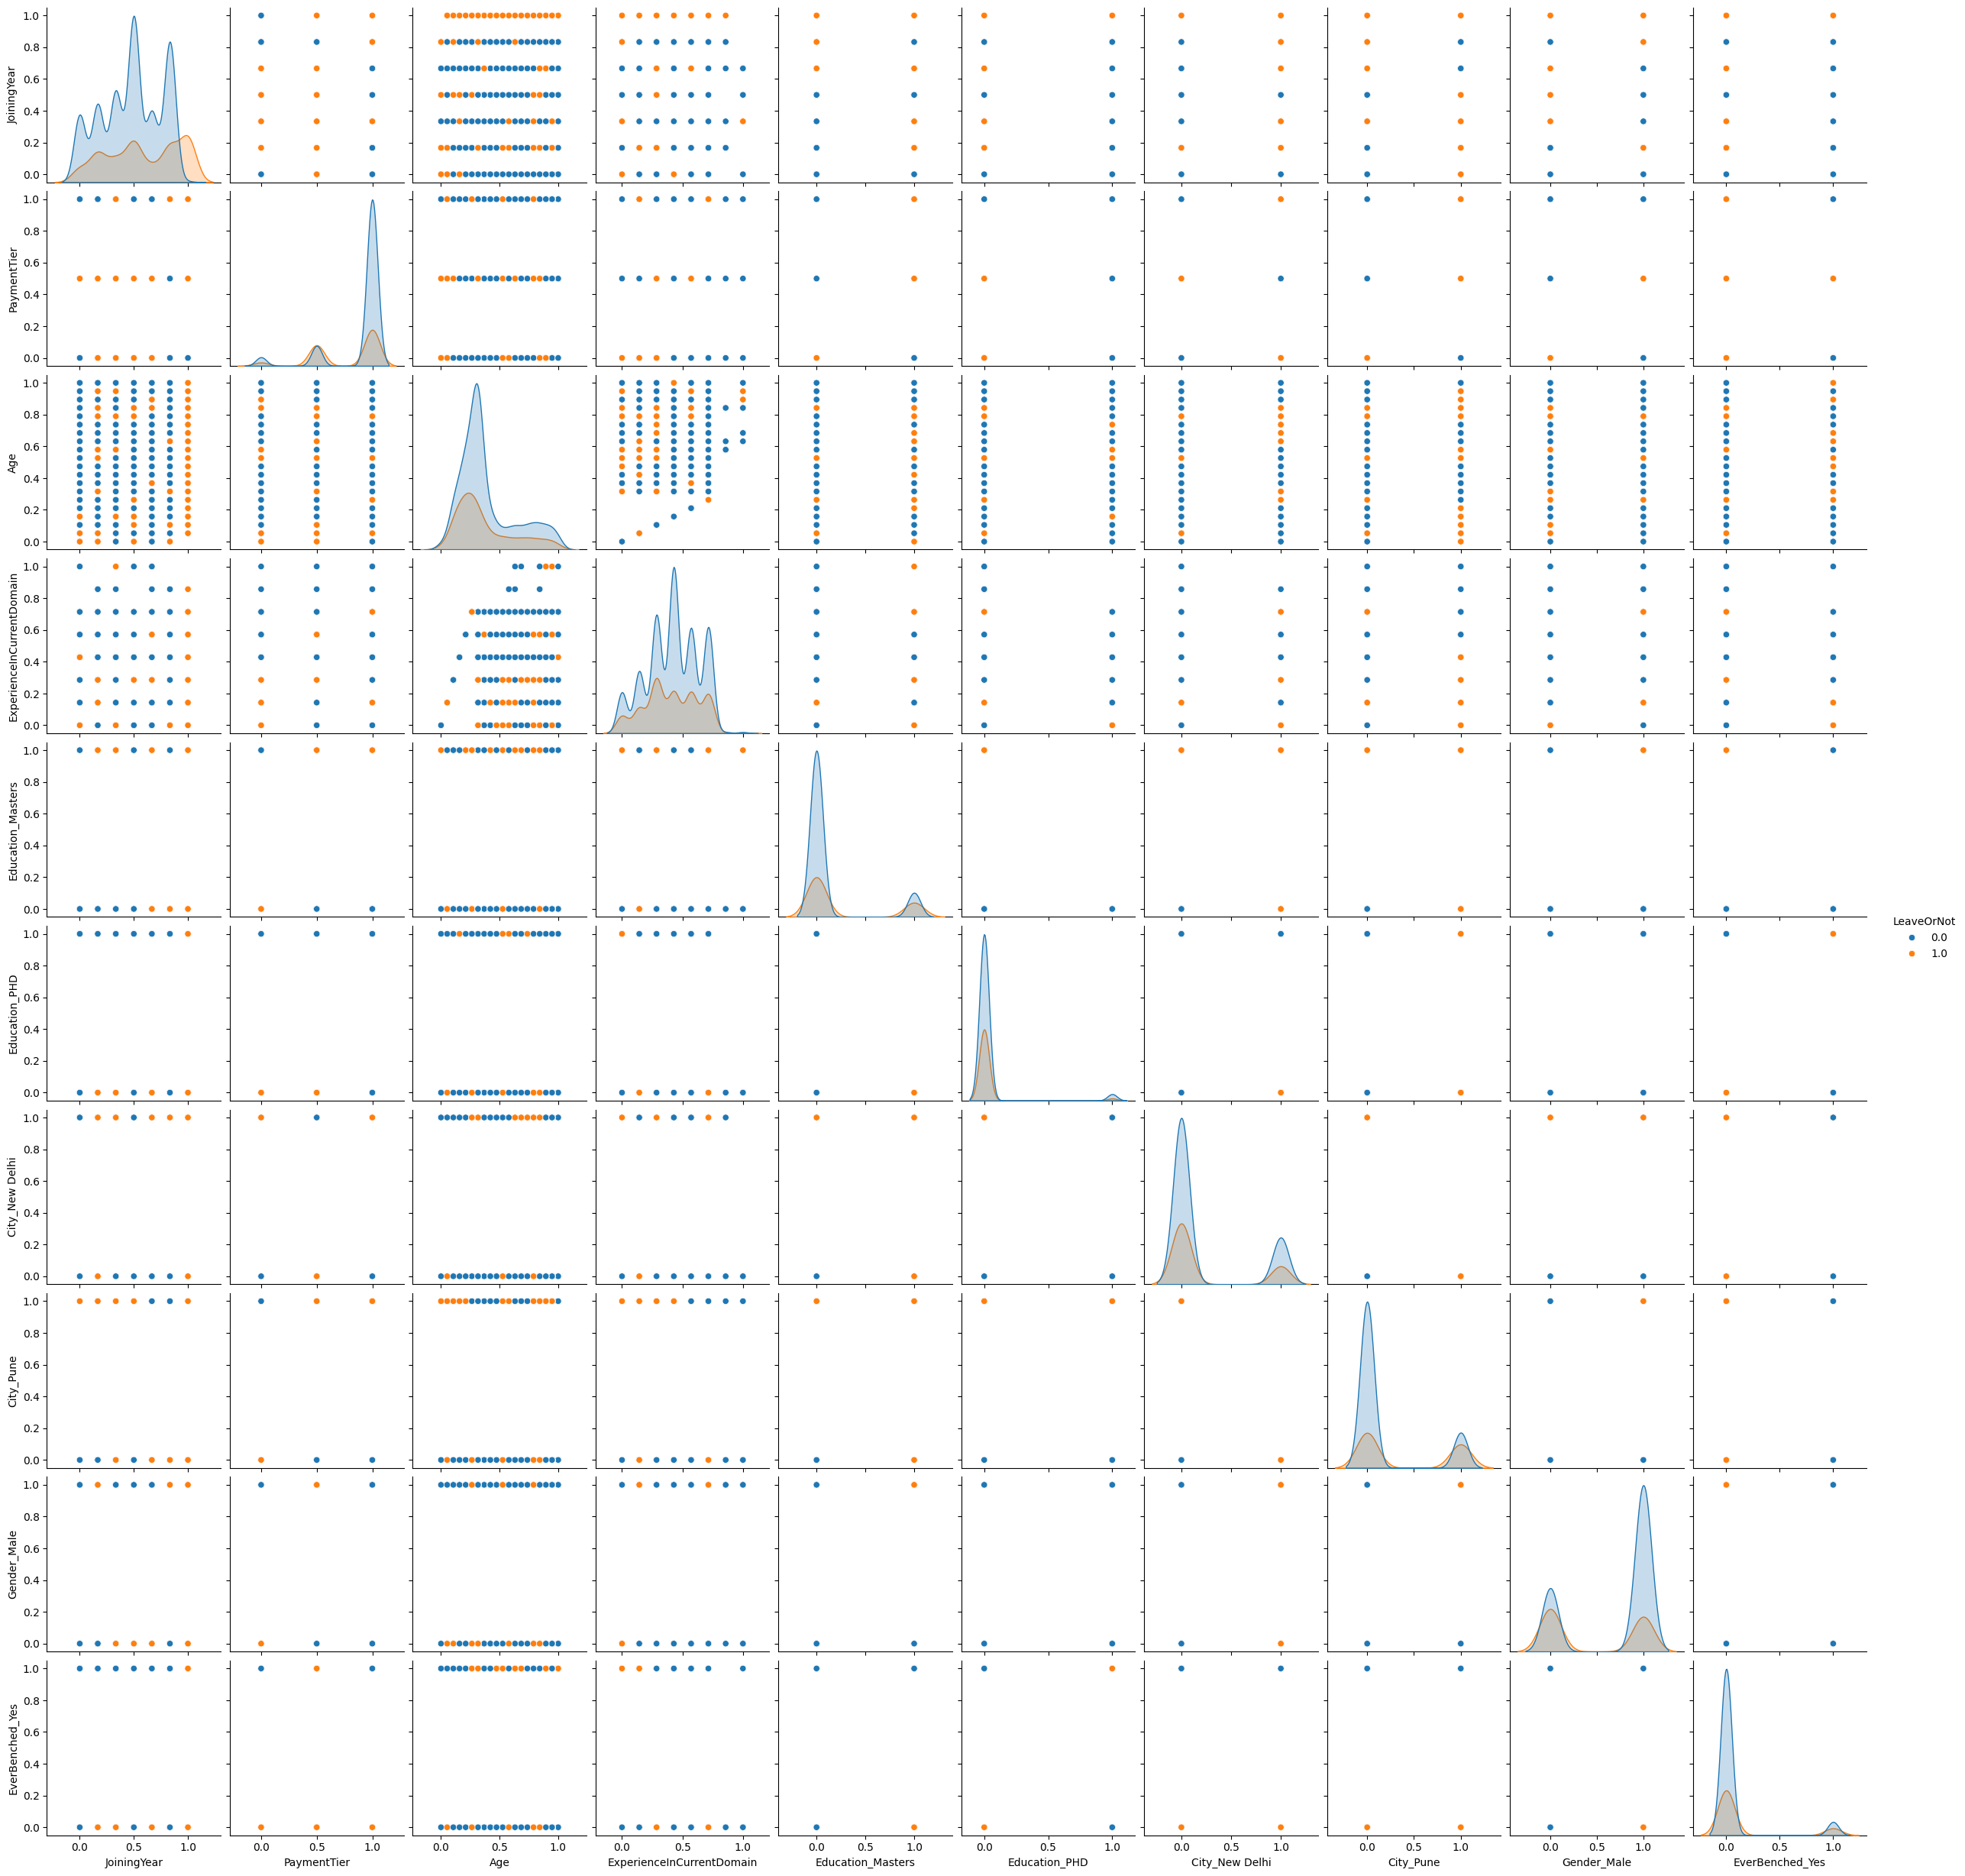

In [411]:
sns.pairplot(df, hue='LeaveOrNot')

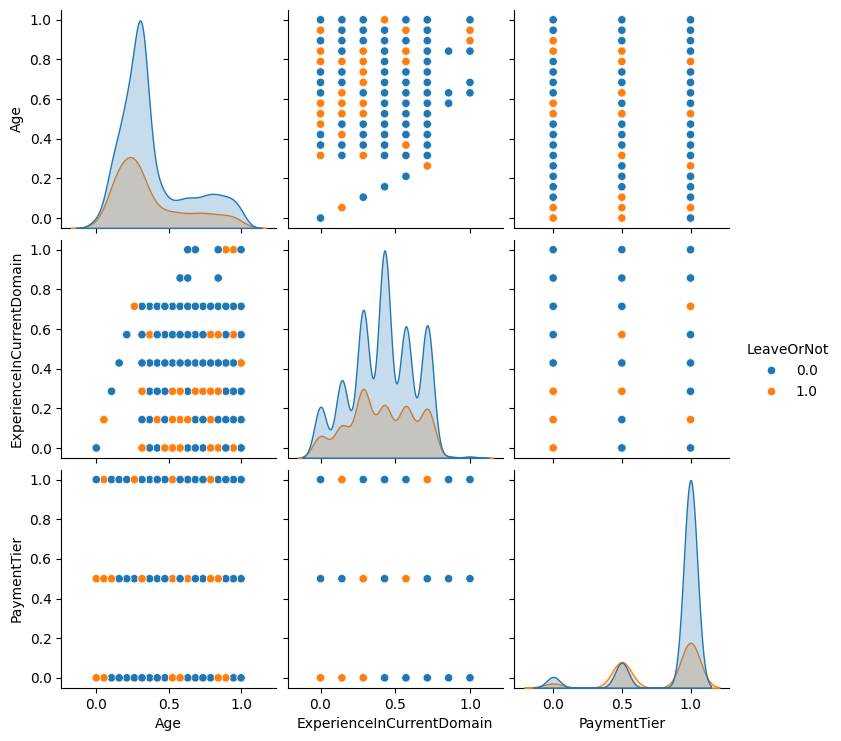

In [412]:
sns.pairplot(df, hue='LeaveOrNot', vars=['Age', 'ExperienceInCurrentDomain', 'PaymentTier'])

### Wnioski z pairplotów:
* Wygląda na to że zmienna `Age` nie ma dużego wpływu na decyzję o odejściu z firmy
* Zmienna `ExperienceInCurrentDomain` wydaje się być bardziej istotna
* Zmienna `PaymentTier` również wydaje się być istotna
* Age i ExperienceInCurrentDomain wykazują logiczną liniową zależność (wyższy wiek koreluje z większym doświadczeniem), ale ta zależność może nie różnić się znacząco między klasami.

<Axes: xlabel='Age', ylabel='ExperienceInCurrentDomain'>

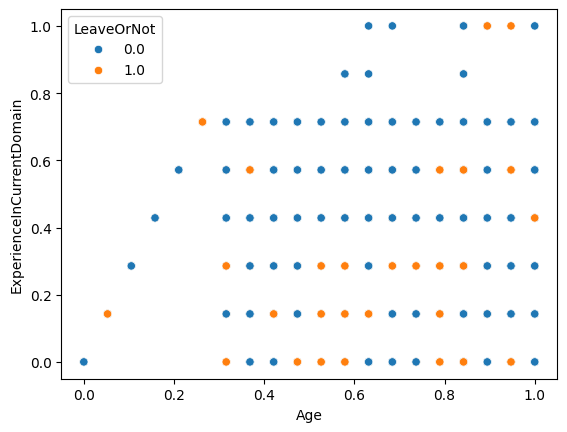

In [413]:
sns.scatterplot(data=df, x='Age', y='ExperienceInCurrentDomain', hue='LeaveOrNot')

<Axes: xlabel='PaymentTier', ylabel='ExperienceInCurrentDomain'>

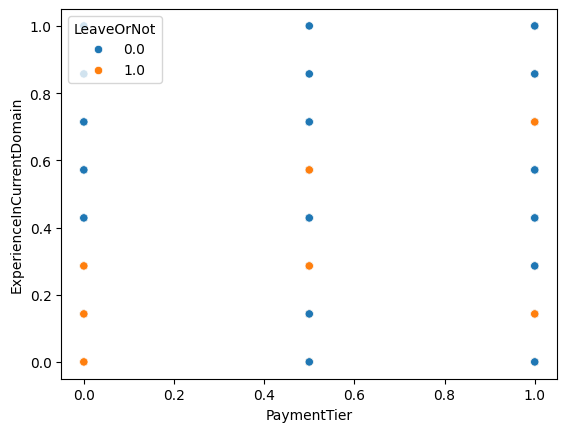

In [414]:
sns.scatterplot(data=df, x='PaymentTier', y='ExperienceInCurrentDomain', hue='LeaveOrNot')

In [415]:
from scipy.stats import chi2_contingency, f_oneway

contingency_table = pd.crosstab(df['PaymentTier'], df['LeaveOrNot'])

results = {}

# Chi-square test
contingency_table = pd.crosstab(df['PaymentTier'], df['LeaveOrNot'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
results['Chi-Square (PaymentTier and LeaveOrNot)'] = {
    'Chi2 Statistic': chi2,
    'p-value': p,
    'Degrees of Freedom': dof
}

# ANOVA for ExperienceInCurrentDomain
group_0 = df[df['LeaveOrNot'] == 0]['ExperienceInCurrentDomain']
group_1 = df[df['LeaveOrNot'] == 1]['ExperienceInCurrentDomain']
f_stat, p_value = f_oneway(group_0, group_1)
results['ANOVA (ExperienceInCurrentDomain and LeaveOrNot)'] = {
    'F-Statistic': f_stat,
    'p-value': p_value
}

# ANOVA for Age
group_0 = df[df['LeaveOrNot'] == 0]['Age']
group_1 = df[df['LeaveOrNot'] == 1]['Age']
f_stat, p_value = f_oneway(group_0, group_1)
results['ANOVA (Age and LeaveOrNot)'] = {
    'F-Statistic': f_stat,
    'p-value': p_value
}

for test, metrics in results.items():
    print(f"\n{test}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


Chi-Square (PaymentTier and LeaveOrNot):
  Chi2 Statistic: 409.4476328803018
  p-value: 1.2290688329761638e-89
  Degrees of Freedom: 2

ANOVA (ExperienceInCurrentDomain and LeaveOrNot):
  F-Statistic: 4.173413512290081
  p-value: 0.04111924575352596

ANOVA (Age and LeaveOrNot):
  F-Statistic: 4.6157695789542545
  p-value: 0.03173075804105326


### Wnioski z testów statystycznych

1. Relacja między PaymentTier a LeaveOrNot:
* Bardzo niski poziom istotności statystycznej wskazuje na silną zależność między poziomem wynagrodzenia (PaymentTier) a decyzją o odejściu z pracy (LeaveOrNot).
* Wynika z tego, że wynagrodzenie jest kluczowym czynnikiem wpływającym na retencję pracowników.

2. Relacja między ExperienceInCurrentDomain a LeaveOrNot:
* Wynik ANOVA (p-value: 0.0411) sugeruje, że istnieje istotna różnica w doświadczeniu w obecnej domenie (ExperienceInCurrentDomain) między pracownikami, którzy odeszli, a tymi, którzy zostali.
* Chociaż efekt jest istotny, nie jest on tak silny jak w przypadku PaymentTier.

3. Relacja między Age a LeaveOrNot:
* Wynik ANOVA (p-value: 0.0317) wskazuje, że wiek (Age) również istotnie wpływa na decyzję o pozostaniu lub odejściu z pracy.
* Wpływ wieku jest istotny, ale prawdopodobnie bardziej subtelny niż wpływ wynagrodzenia.

**Podsumowanie:**

Wynagrodzenie (PaymentTier) jest najważniejszym czynnikiem wpływającym na retencję pracowników, ale doświadczenie w obecnej domenie (ExperienceInCurrentDomain) i wiek (Age) również odgrywają istotną rolę.